In [5]:
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
import numpy as np

In [6]:
df = pd.read_csv('sierad.csv')
df.head()

,Room_T,RH,Teff,Wind_Speed
0,35,30,35.0,0.0
1,35,30,34.3,0.1
2,35,30,33.0,0.3
3,35,30,31.6,0.5
4,35,30,29.8,0.7


In [33]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, GeneralizedLinearRegression, GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [8]:
df.dtypes

Room_T          int64
RH              int64
Teff          float64
Wind_Speed    float64
dtype: object

In [9]:
data = spark.createDataFrame(df)

In [10]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [11]:
data.show(5)

+------+---+----+----------+
|Room_T| RH|Teff|Wind_Speed|
+------+---+----+----------+
|    35| 30|35.0|       0.0|
|    35| 30|34.3|       0.1|
|    35| 30|33.0|       0.3|
|    35| 30|31.6|       0.5|
|    35| 30|29.8|       0.7|
+------+---+----+----------+
only showing top 5 rows



In [12]:
from pyspark.ml.feature import VectorAssembler
vac = VectorAssembler(inputCols=["Room_T", "RH", "Teff"], outputCol="features")
va = vac.transform(data)

In [13]:
va.show(5)

+------+---+----+----------+----------------+
|Room_T| RH|Teff|Wind_Speed|        features|
+------+---+----+----------+----------------+
|    35| 30|35.0|       0.0|[35.0,30.0,35.0]|
|    35| 30|34.3|       0.1|[35.0,30.0,34.3]|
|    35| 30|33.0|       0.3|[35.0,30.0,33.0]|
|    35| 30|31.6|       0.5|[35.0,30.0,31.6]|
|    35| 30|29.8|       0.7|[35.0,30.0,29.8]|
+------+---+----+----------+----------------+
only showing top 5 rows



In [14]:
est = RandomForestRegressor()
{param[0].name: param[1] for param in est.extractParamMap().items()}

{'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featureSubsetStrategy': 'auto',
 'featuresCol': 'features',
 'impurity': 'variance',
 'labelCol': 'label',
 'maxBins': 32,
 'maxDepth': 5,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'numTrees': 20,
 'predictionCol': 'prediction',
 'seed': -5851613654371098793,
 'subsamplingRate': 1.0}

In [45]:
rf = RandomForestRegressor(numTrees=500, maxDepth=25, maxBins=128, seed=32, featuresCol='features', labelCol='Wind_Speed')
glr = GeneralizedLinearRegression(labelCol='Wind_Speed', featuresCol='features', predictionCol='prediction',\
                                  family="gaussian", link="identity", linkPredictionCol="p", fitIntercept=True, maxIter=150,\
                                  tol=1e-06, regParam=0.0, solver='irls')
gbt = GBTRegressor(featuresCol='features', labelCol='Wind_Speed', predictionCol='prediction',\
                   maxDepth=5, maxBins=64, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256,\
                   cacheNodeIds=False, subsamplingRate=1.0, checkpointInterval=10, lossType='squared',\
                   maxIter=200, stepSize=0.1, seed=None)

In [181]:
pipeline = Pipeline(stages=[vac, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [17]:
predictions.show()

+------+---+----+----------+----------------+------------------+
|Room_T| RH|Teff|Wind_Speed|        features|        prediction|
+------+---+----+----------+----------------+------------------+
|    21| 30|18.4|       2.3|[21.0,30.0,18.4]|1.2714766311676728|
|    21| 30|18.8|       1.5|[21.0,30.0,18.8]|1.2433434008008026|
|    21| 30|22.7|       0.3|[21.0,30.0,22.7]|0.9690444047238214|
|    21| 35|17.9|       2.3|[21.0,35.0,17.9]|1.3269623767094705|
|    21| 35|19.1|       1.3|[21.0,35.0,19.1]|1.2425626856088605|
|    21| 35|20.0|       0.9|[21.0,35.0,20.0]|1.1792629172834035|
|    21| 35|20.5|       0.7|[21.0,35.0,20.5]| 1.144096379324816|
|    21| 35|22.0|       0.3|[21.0,35.0,22.0]| 1.038596765449054|
|    21| 35|23.0|       0.1|[21.0,35.0,23.0]|0.9682636895318792|
|    21| 40|17.2|       2.5|[21.0,40.0,17.2]|1.3965147374347033|
|    21| 40|17.5|       2.1|[21.0,40.0,17.5]|1.3754148146595506|
|    21| 40|20.3|       0.5|[21.0,40.0,20.3]|1.1784822020914616|
|    21| 45|17.0|       2

In [41]:
pipeline = Pipeline(stages=[vac, glr])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [42]:
predictions.show()

+------+---+----+----------+----------------+--------------------+--------------------+
|Room_T| RH|Teff|Wind_Speed|        features|          prediction|                   p|
+------+---+----+----------+----------------+--------------------+--------------------+
|    21| 30|18.4|       2.3|[21.0,30.0,18.4]|  0.8036618389485192|  0.8036618389485192|
|    21| 30|18.8|       1.5|[21.0,30.0,18.8]|  0.7128972964298989|  0.7128972964298989|
|    21| 30|22.7|       0.3|[21.0,30.0,22.7]|-0.17205699312664302|-0.17205699312664302|
|    21| 35|17.9|       2.3|[21.0,35.0,17.9]|    1.02948837660576|    1.02948837660576|
|    21| 35|19.1|       1.3|[21.0,35.0,19.1]|  0.7571947490499001|  0.7571947490499001|
|    21| 35|20.0|       0.9|[21.0,35.0,20.0]|  0.5529745283830062|  0.5529745283830062|
|    21| 35|20.5|       0.7|[21.0,35.0,20.5]|  0.4395188502347317|  0.4395188502347317|
|    21| 35|22.0|       0.3|[21.0,35.0,22.0]| 0.09915181578990728| 0.09915181578990728|
|    21| 35|23.0|       0.1|[21.

In [46]:
pipeline = Pipeline(stages=[vac, gbt])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

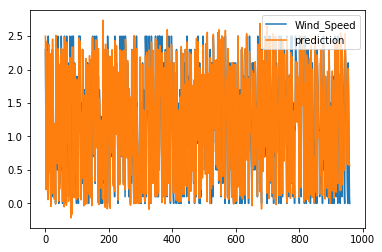

In [49]:
predictions.select('Wind_Speed', 'prediction').toPandas().plot()

In [109]:
# Select example rows to display.
predictions.select("prediction", "Wind_Speed", "features").show(5)


+------------------+----------+----------------+
|        prediction|Wind_Speed|        features|
+------------------+----------+----------------+
|               2.0|       2.5|[21.0,30.0,18.3]|
|1.8333333333333333|       1.9|[21.0,30.0,18.6]|
|1.8333333333333333|       1.5|[21.0,30.0,18.8]|
|1.2450757575757576|       1.1|[21.0,30.0,20.0]|
|0.9607620320855617|       0.9|[21.0,30.0,20.5]|
+------------------+----------+----------------+
only showing top 5 rows



In [110]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Wind_Speed", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]
print(rfModel)  # summary only

Root Mean Squared Error (RMSE) on test data = 0.295401
RandomForestRegressionModel (uid=RandomForestRegressor_45e0973ae2c072eb1e59) with 3 trees


In [183]:
predictions.select("prediction").collect.map(_.getDouble(0))

AttributeError: 'function' object has no attribute 'map'

In [187]:
predictionspd = predictions.toPandas()

In [189]:
predictionspd.shape

(961, 6)

In [190]:
from sklearn.metrics import r2_score

In [192]:
r2_score(predictionspd.Wind_Speed.values, predictionspd.prediction.values)

0.9105423601390011

In [188]:
predictionspd.select(predictions("prediction")).first().getList[Double](0)

TypeError: 'DataFrame' object is not callable

In [193]:
predictionspd.head()

,Room_T,RH,Teff,Wind_Speed,features,prediction
0,21,30,18.3,2.5,"[21.0, 30.0, 18.3]",1.803081
1,21,30,18.6,1.9,"[21.0, 30.0, 18.6]",1.697459
2,21,30,18.8,1.5,"[21.0, 30.0, 18.8]",1.481947
3,21,30,20.0,1.1,"[21.0, 30.0, 20.0]",1.089502
4,21,30,20.5,0.9,"[21.0, 30.0, 20.5]",0.892898


In [194]:
predictionspd.to_pickle("./sierad.pkl")

In [196]:
df = pd.read_pickle('sierad.pkl')

In [197]:
df

,Room_T,RH,Teff,Wind_Speed,features,prediction
0,21,30,18.3,2.5,"[21.0, 30.0, 18.3]",1.803081
1,21,30,18.6,1.9,"[21.0, 30.0, 18.6]",1.697459
2,21,30,18.8,1.5,"[21.0, 30.0, 18.8]",1.481947
3,21,30,20.0,1.1,"[21.0, 30.0, 20.0]",1.089502
4,21,30,20.5,0.9,"[21.0, 30.0, 20.5]",0.892898
5,21,30,21.1,0.7,"[21.0, 30.0, 21.1]",0.765471
6,21,30,21.6,0.5,"[21.0, 30.0, 21.6]",0.640067
7,21,35,20.5,0.7,"[21.0, 35.0, 20.5]",0.789855
8,21,35,23.6,0.0,"[21.0, 35.0, 23.6]",0.311771
9,21,40,17.2,2.5,"[21.0, 40.0, 17.2]",1.954470
